### Data preparation

#### Defining imports and global variables

In [10]:
import gif
import datetime
import cartopy
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
from IPython import display
import matplotlib.pyplot as plt
from matplotlib import animation
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid

import shutup; shutup.please()

In [2]:
def datestr2datetime(row):
    y, m, d, h = [int(row[:4]), int(row[4:6]), int(row[6:8]), int(row[8:])]
    return datetime.datetime(y, m, d, h-1)
    
sd = datetime.datetime(2023, 9, 1)
ed = datetime.datetime(2023, 9, 2)

extent_nl = (3, 8, 50, 54)

projection_latlon = ccrs.PlateCarree()
projection_rdnew = ccrs.epsg(28992)

resolution = "50m"

boundaries = cartopy.feature.NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale=resolution, facecolor='none', alpha=0.7)
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale=resolution, edgecolor='k', facecolor=cfeature.COLORS['land_alt1'])
ocean = cartopy.feature.NaturalEarthFeature('physical', 'ocean', scale=resolution, edgecolor='none', facecolor=cfeature.COLORS['water'])
lakes = cartopy.feature.NaturalEarthFeature('physical', 'lakes', scale=resolution, edgecolor='k', facecolor=cfeature.COLORS['water'])

path_wow = r"~/work/private/data-common/raw_wow_livestream/WOW_2023-09-01T00_00_00Z_2023-09-02T00_00_00Z.csv"
path_qc = r"~/work/private/data-common/qc_wow_sample/qc_WOW_2023-09-01T00_00_00Z_2023-09-02T00_00_00Z.csv"
path_contour = r"~/work/private/geodata/vector/NL_shapefile_WGS84/NL_WGS84.shp"
path_uur = r"~/work/private/data-common/KNMI/daggegevens/Sep23_uurgegevens.txt"


#### Processing the dataframes for visualization

In [3]:
# Reading the contour of the Netherlands for further spatial filtering
gdf_nl = gpd.read_file(path_contour)

# Reading the 'uurgegevens' for comparison purposes and doing sanity checks
df_uur = pd.read_csv(path_uur, skiprows=78, sep=",", header=0, index_col=False, parse_dates=[["YYYYMMDD", "H"]], date_parser=datestr2datetime)
df_uur.columns = df_uur.columns.str.strip()
df_uur = df_uur.replace('\s+', np.nan, regex=True) 
df_uur = df_uur.loc[(df_uur['YYYYMMDD_H'] >= sd) & (df_uur['YYYYMMDD_H'] < ed)]

# Reading the WOW observations and their quality control to put them together
df_qc = pd.read_csv(path_qc, sep=",", header=0)
df_wow = pd.read_csv(path_wow, sep=",", header=0, parse_dates=["CreatedDateTime", "ReportEndDateTime", "LocalReportEndDateTime"])
df_all = pd.concat([df_wow, df_qc], axis=1)

# Turning the combined dataset into a geospatial one, so that we can figure out whether
# each row is in/out the Netherlands with a spatial join operation
gdf_all = gpd.GeoDataFrame(df_all, geometry=gpd.points_from_xy(df_all.Longitude, df_all.Latitude), crs="EPSG:4326")
gdf_sjoin = gpd.sjoin(gdf_all, gdf_nl, how='left', op='within')
gdf_in = gdf_sjoin.query("index_right == 0")
gdf_out = gdf_sjoin.query("index_right != 0")

### Visualizations

#### Make small 'dashboard' visualizing some aspects of quality

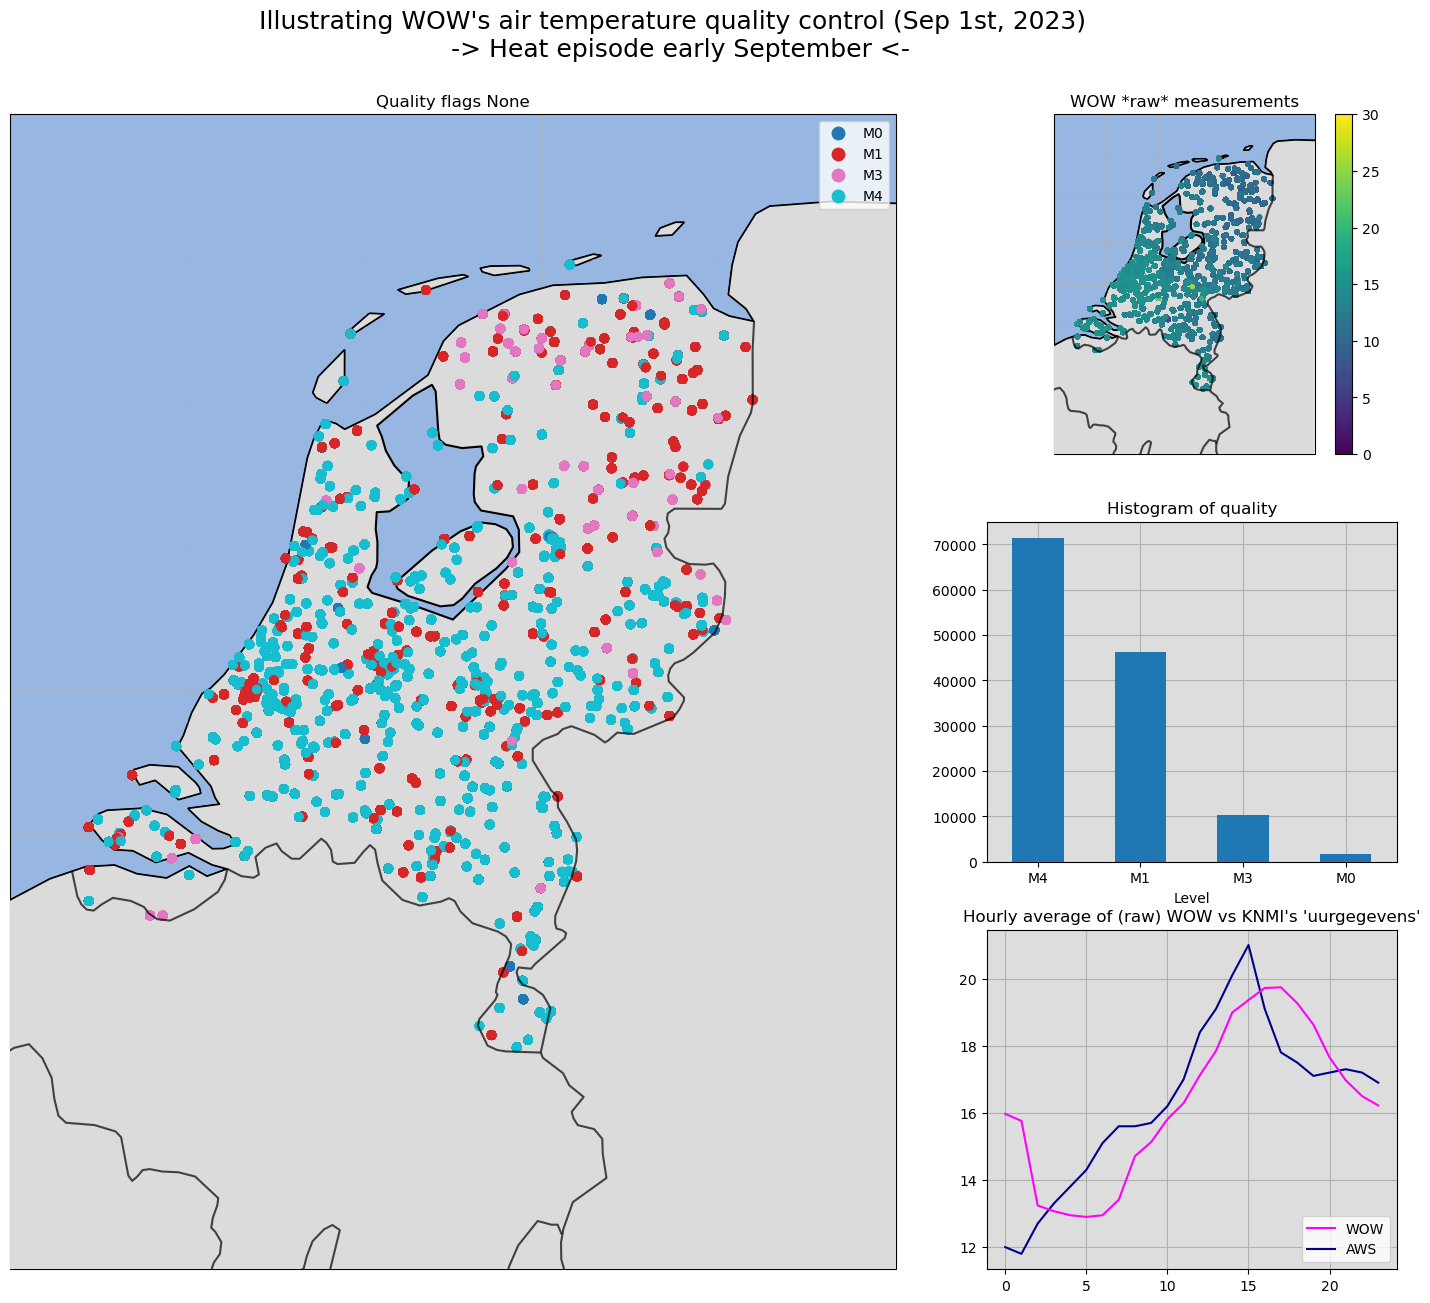

In [4]:
# Define the function drawing a frame to visualize

def draw_dashboard(gdf_in, df_uur, date_str=None):
    fig = plt.figure(figsize=(18, 15), layout="constrained")
    gs = GridSpec(3, 3)
    
    # Map subplot with quality
    ax1 = fig.add_subplot(gs[:, 0:2], projection = projection_latlon)
    ax1.set_title("Quality flags {0}".format(date_str))
    ax1.set_extent(extent_nl, crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='-', linewidth=0.5)
    ax1.add_feature(ocean, zorder=1)
    ax1.coastlines(resolution=resolution, linewidth=1.5, zorder=2)
    ax1.add_feature(land, zorder=3)
    ax1.add_feature(lakes, linewidth=1.5, zorder=4)

    if gdf_in.shape[0] > 0:
        gdf_in.plot(column="Level", legend=True, ax=ax1, zorder=5)
    ax1.add_feature(boundaries, linestyle='-', linewidth=1.5, zorder=6)
    
    # Map subplot with raw WOW measurements
    ax2 = fig.add_subplot(gs[0, 2], projection = projection_latlon)
    ax2.set_title("WOW *raw* measurements")
    ax2.set_extent(extent_nl, crs=ccrs.PlateCarree())
    ax2.gridlines(linestyle='-', linewidth=0.5)
    ax2.add_feature(ocean, zorder=1)
    ax2.coastlines(resolution=resolution, linewidth=1.5, zorder=2)
    ax2.add_feature(land, zorder=3)
    ax2.add_feature(lakes, linewidth=1.5, zorder=4)
    
    if gdf_in.shape[0] > 0:
        gdf_in.plot(column="DryBulbTemperature_Celsius", legend=True, ax=ax2, markersize=8, vmin=0, vmax=30, zorder=5)
    ax2.add_feature(boundaries, linestyle='-', linewidth=1.5, zorder=6)
    
    # Histogram subplot of quality
    ax3 = fig.add_subplot(gs[1, 2])
    if gdf_in.shape[0] > 0:
        gdf_in["Level"].value_counts().plot.bar(rot=0, ax=ax3, zorder=5)
    else:
        pass
    ax3.set_facecolor("#DDDDDD")
    ax3.grid()
    ax3.set_title("Histogram of quality")
    
    # Hourly average WOW vs AWS
    xlinspace = np.linspace(0, 23, 24)
    ax4 = fig.add_subplot(gs[2, 2])
    ax4.set_facecolor("#DDDDDD")
    ax4.grid()
    
    lwow, laws = [[] for i in range(2)]
    groups_wow_hour = gdf_in[["LocalReportEndDateTime", "DryBulbTemperature_Celsius"]].groupby(gdf_in["LocalReportEndDateTime"].dt.hour)
    for idx, wow_group in groups_wow_hour:
        # print("Hour: ", np.unique(wow_group["LocalReportEndDateTime"].dt.hour, return_counts=True)) 
        lwow.append(np.round(wow_group["DryBulbTemperature_Celsius"].mean(), 2))
    
    groups_aws_hour = df_uur[["YYYYMMDD_H", "T"]].groupby(df_uur["YYYYMMDD_H"].dt.hour)
    for idx, aws_group in groups_aws_hour:
        laws.append(np.round(np.divide(aws_group["T"].mean(skipna=True), 10), 2))

    # This is for the 15-min aggregation frames
    if len(lwow) == 1:
        
        current_hour = gdf_in.iloc[0]["LocalReportEndDateTime"].hour
        ax4.plot(current_hour, lwow[0], label="WOW", marker="o", color="magenta", zorder=5)
    elif len(lwow) == 0:
        pass
    else:
        ax4.plot(xlinspace, lwow, label="WOW", color="magenta", zorder=5)
        
    ax4.plot(xlinspace, laws, label="AWS", color="darkblue", zorder=4)
    ax4.legend(loc='lower right')    
    ax4.set_title("Hourly average of (raw) WOW vs KNMI\'s \'uurgegevens\'")
    
    fig.suptitle("Illustrating WOW\'s air temperature quality control (Sep 1st, 2023) \n -> Heat episode early September <-", y=0.95, size=18)
    # plt.savefig("./data-common/outputs_png/quality_demo/vis-quality-one-day.png", dpi=300)


# Run the function on the daily dataframe
draw_dashboard(gdf_in, df_uur)

#### Visualizing the quality at 15-min intervals

In this cell we run this in blocks of X-min and we make an animation of the quality

In [6]:
# Calling the drawing function in a loop

plt.clf()

@gif.frame
def plot_aux(group, df_uur, date_str):
     draw_dashboard(group, df_uur, date_str)

frames = []
stop_at = 60
groups_15m = gdf_in.groupby(pd.Grouper(key='LocalReportEndDateTime', axis=0, freq='15min'))
for idx, group in groups_15m:
    print("Processing: ", idx)
    frame = plot_aux(group, df_uur, idx)
    frames.append(frame)
    if stop_at == 0:
        break
    else:
        stop_at-=1

path_gif = r"/home/jovyan/work/private/data-common/outputs_png/quality_demo/vis-quality-basic.gif"
gif.save(frames, path_gif, duration=2000)
del frames
plt.close('all')

Processing:  2023-09-01 00:00:00
Processing:  2023-09-01 00:15:00
Processing:  2023-09-01 00:30:00
Processing:  2023-09-01 00:45:00
Processing:  2023-09-01 01:00:00
Processing:  2023-09-01 01:15:00
Processing:  2023-09-01 01:30:00
Processing:  2023-09-01 01:45:00
Processing:  2023-09-01 02:00:00
Processing:  2023-09-01 02:15:00
Processing:  2023-09-01 02:30:00
Processing:  2023-09-01 02:45:00
Processing:  2023-09-01 03:00:00
Processing:  2023-09-01 03:15:00
Processing:  2023-09-01 03:30:00
Processing:  2023-09-01 03:45:00
Processing:  2023-09-01 04:00:00
Processing:  2023-09-01 04:15:00
Processing:  2023-09-01 04:30:00
Processing:  2023-09-01 04:45:00
Processing:  2023-09-01 05:00:00
Processing:  2023-09-01 05:15:00
Processing:  2023-09-01 05:30:00
Processing:  2023-09-01 05:45:00
Processing:  2023-09-01 06:00:00
Processing:  2023-09-01 06:15:00
Processing:  2023-09-01 06:30:00
Processing:  2023-09-01 06:45:00
Processing:  2023-09-01 07:00:00
Processing:  2023-09-01 07:15:00
Processing

In [13]:
from IPython.display import Image
#Image(url='/home/jovyan/work/private/data-common/outputs_png/quality_demo/vis-quality-basic.gif')
Image(open('Image(open('Animhorse.gif','rb').read())','rb').read())

# display.HTML('<img src="/home/jovyan/work/private/data-common/outputs_png/quality_demo/vis-quality-basic.gif">')

In [ ]:
# When connected to Livestream; find recurrent places of poor quality